In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
data_path = "/kaggle/input/wheat-plant-diseases/data/train" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [4]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [5]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (10483, 2)
Validation set shape: (1310, 2)
Test set shape: (1311, 2)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator()  


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 10483 validated image filenames belonging to 15 classes.
Found 1310 validated image filenames belonging to 15 classes.
Found 1311 validated image filenames belonging to 15 classes.


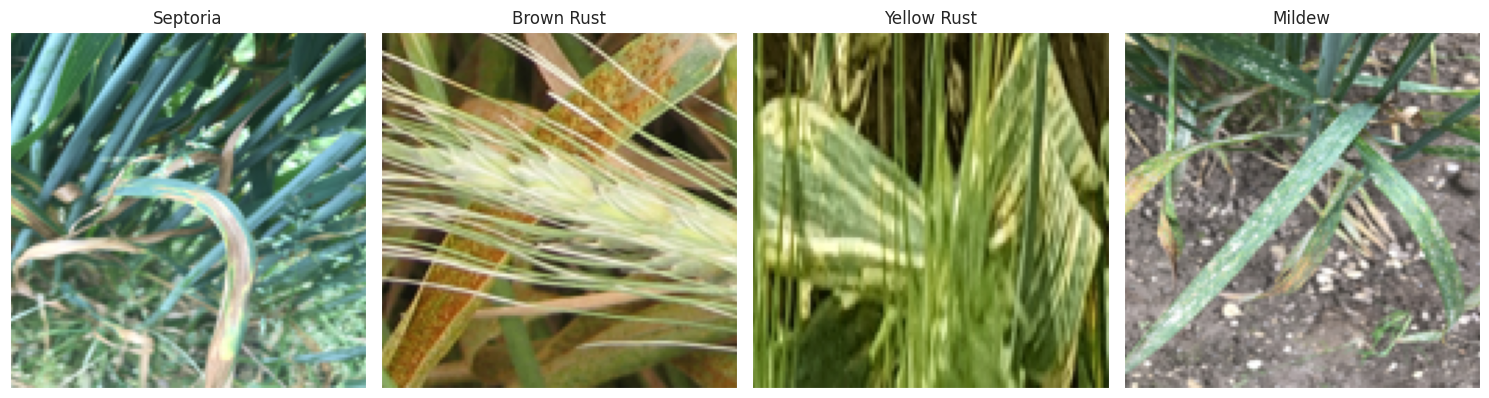

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

class_samples = []

for label in test_df['label'].unique():
    sample = test_df[test_df['label'] == label].iloc[0]  
    class_samples.append((sample['image'], sample['label']))

target_size = (128, 128)  

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (filepath, label) in zip(axes, class_samples):
    img = Image.open(filepath)
    img_resized = img.resize(target_size)
    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('Display_images.jpg', dpi=1200)
plt.show()

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.99) or (val_accuracy and val_accuracy > 0.99):
            print("\nReached 99% accuracy in training or validation, so cancelling training!")

In [11]:
model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(150, 150, 3)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())  

model.add(Dropout(0.3))  

model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))


model.add(Dense(15, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))  



model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 146, 146, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 73, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 71, 71, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 69, 69, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 34, 34, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 30, 30, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 308,751 (1.18 MB)

 Trainable params: 308,111 (1.18 MB)

 Non-trainable params: 640 (2.50 KB)

In [13]:
import time

start_time = time.time()

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=15,
    batch_size=32,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")
print(f"Time per epoch: {training_time/50:.2f} seconds")

Epoch 1/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 310s 902ms/step - accuracy: 0.1976 - loss: 2.5743 - val_accuracy: 0.2527 - val_loss: 2.3719
Epoch 2/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 214s 638ms/step - accuracy: 0.2804 - loss: 2.3147 - val_accuracy: 0.3130 - val_loss: 2.3580
Epoch 3/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 222s 663ms/step - accuracy: 0.3210 - loss: 2.1818 - val_accuracy: 0.3252 - val_loss: 2.1622
Epoch 4/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 212s 634ms/step - accuracy: 0.3521 - loss: 2.0739 - val_accuracy: 0.3817 - val_loss: 2.0459
Epoch 5/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 216s 646ms/step - accuracy: 0.3933 - loss: 1.9807 - val_accuracy: 0.2611 - val_loss: 3.0303
Epoch 6/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 220s 657ms/step - accuracy: 0.4241 - loss: 1.8568 - val_accuracy: 0.4603 - val_loss: 1.7110
Epoch 7/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 217s 647ms/step - accuracy: 0.4477 - loss: 1.7732 - val_accuracy: 0.4489 - val_loss: 1.9529
Epoch 8/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 210s 626ms/step - accuracy: 0.4804 -

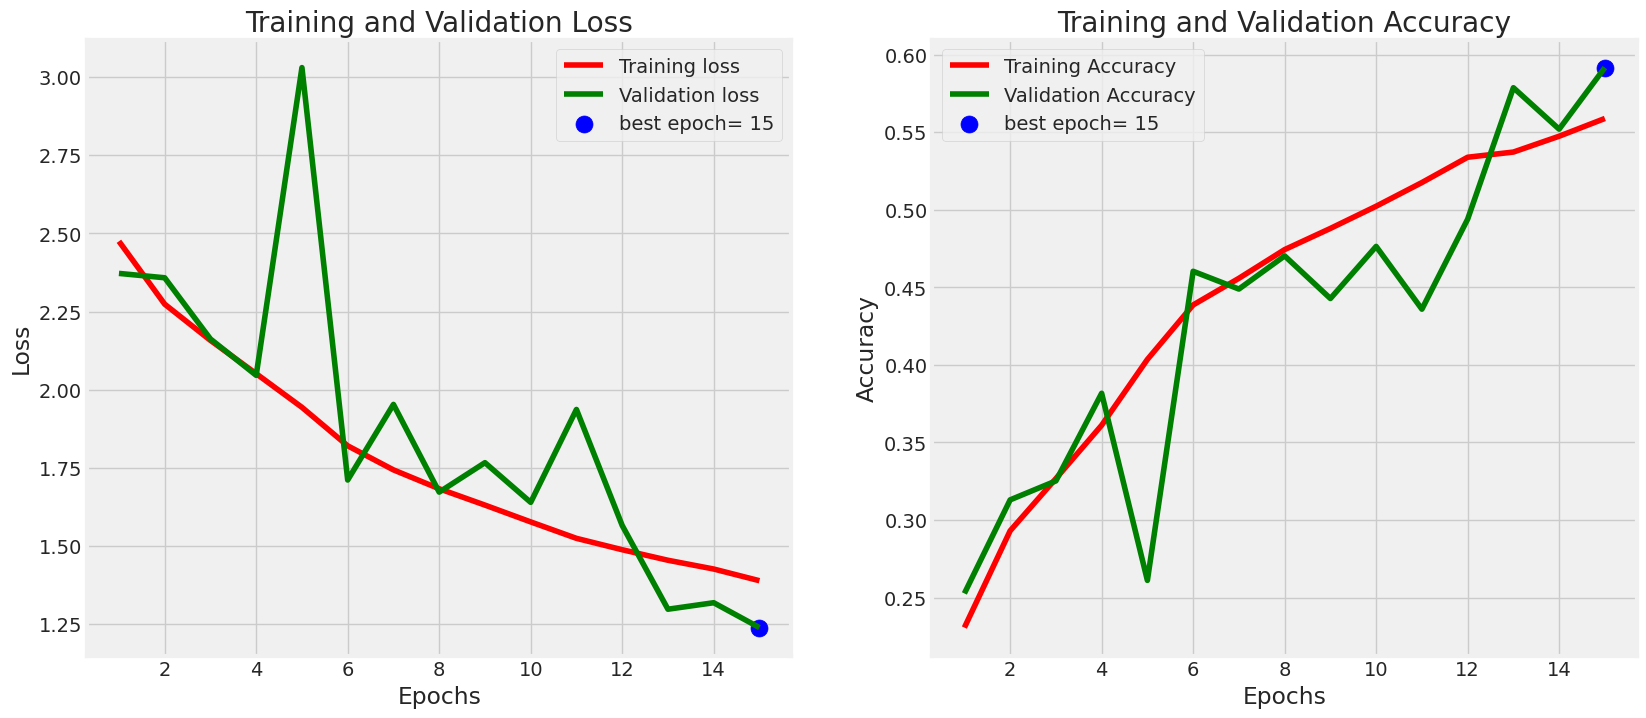

In [14]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step - accuracy: 0.5813 - loss: 1.3209
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - accuracy: 0.5753 - loss: 1.2600
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 813ms/step - accuracy: 0.5817 - loss: 1.2951
Train Loss:  1.3288516998291016
Train Accuracy:  0.5674341917037964
--------------------
Valid Loss:  1.2423747777938843
Valid Accuracy:  0.5921052694320679
--------------------
Test Loss:  1.290479302406311
Test Accuracy:  0.5789473652839661


In [17]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 677ms/step


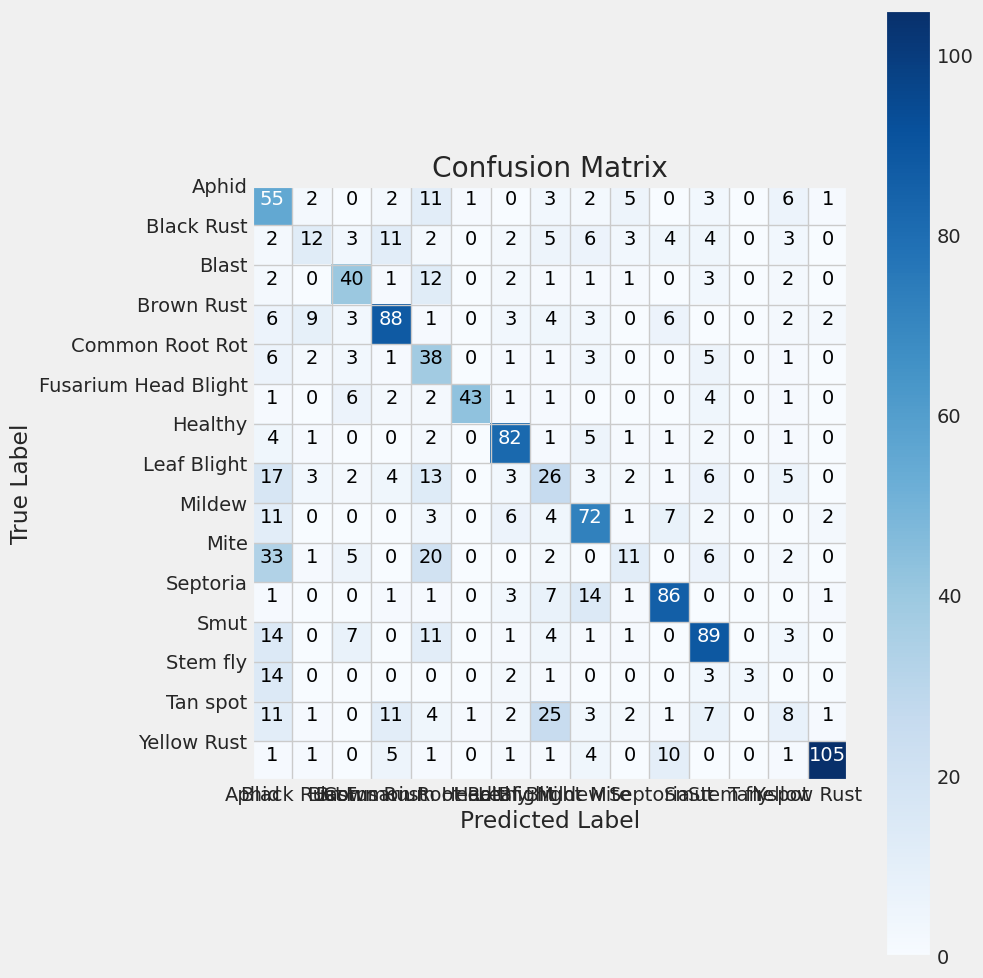

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()